# Variational AutoEncoder - LeNet300 + MNIST + TF2

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import pickle

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-03-15 16:01:58.917859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:01:58.964665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:01:58.964763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:01:58.965397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MNIST Data Pre-processing

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
print(f"input_shape to be used: {input_shape}")

input_shape to be used: (28, 28, 1)


In [10]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 50

In [11]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [12]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [ ]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [14]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000,)
X_test.shape: (10000, 784), y_test.shape: (10000,)


In [15]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

2022-03-15 16:02:19.271858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 16:02:19.308659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:02:19.309198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:02:19.309628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Define Variational Autoencoder architecture using _dense_ layers

In [17]:
class Encoder(Model):
    def __init__(self, latent_space = 3):
        super(Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 300, activation = None
        )
        self.dense2 = Dense(
            units = 100, activation = None
        )
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.encoder_output(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"Encoder output shape: {x.shape}")
        del x
        return None
        

In [18]:
class Decoder(Model):
    def __init__(self, latent_space = 3):
        super(Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(units = self.latent_space, activation = None)
        self.dense2 = Dense(units = 100, activation = None)
        self.dense3 = Dense(units = 300, activation = None)
        self.decoder_output = Dense(units = 784, activation = None)
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.dense3(x))
        x = self.decoder_output(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.dense3(x)
        print(f"dense3 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"Decoder output shape: {x.shape}")
        del x
        return None
        

#### Sanity check

In [19]:
encoder = Encoder(latent_space = 3)

In [20]:
x = next(iter(train_dataset))

In [21]:
x_enc = encoder(x)

2022-03-15 16:04:30.089733: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [22]:
decoder = Decoder(latent_space = 3)

In [23]:
x_recon = decoder(x_enc)

In [24]:
x.shape, x_recon.shape
# (TensorShape([64, 784]), TensorShape([64, 784]))

(TensorShape([64, 784]), TensorShape([64, 784]))

In [25]:
x_enc.shape
# TensorShape([64, 3])

TensorShape([64, 3])

In [26]:
encoder.shape_computation(x)

Input shape: (64, 784)
dense1 output shape: (64, 300)
dense2 output shape: (64, 100)
Encoder output shape: (64, 3)


In [27]:
decoder.shape_computation(x_enc)

Input shape: (64, 3)
dense1 output shape: (64, 3)
dense2 output shape: (64, 100)
dense3 output shape: (64, 300)
Decoder output shape: (64, 784)


In [28]:
del x, x_enc, x_recon, encoder, decoder

In [29]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Encoder(latent_space = self.latent_space)
        self.decoder = Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.,
            stddev = 1.
        )
        return (eps * tf.exp(logvar * 0.5)) + mu
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 3)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 3), log_var.shape: (batch_size, 3) & z.shape: (batch_size, 3)
        '''
        
        x = tf.keras.activations.sigmoid(self.decoder(z))
        
        return x, mu, log_var
        

In [30]:
# Initialize a VAE model-
model = VAE(latent_space = 3)

In [31]:
# Sanity check-
x = next(iter(train_dataset))

In [32]:
x_recon, mu, log_var = model(x)

In [33]:
x_recon.shape, x.shape

(TensorShape([64, 784]), TensorShape([64, 784]))

In [34]:
mu.shape, log_var.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [35]:
mu.numpy().mean(), mu.numpy().std()

(0.012649395, 0.09325593)

In [36]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.032763954, 0.14971866)

In [37]:
del x, x_recon, mu, log_var

In [38]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  265903    
                                                                 
 decoder_1 (Decoder)         multiple                  266696    
                                                                 
 dense_14 (Dense)            multiple                  12        
                                                                 
 dense_15 (Dense)            multiple                  12        
                                                                 
Total params: 532,623
Trainable params: 532,623
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (784, 300) has 235200 parameters
layer: (300,) has 0 parameters
layer: (300, 100) has 30000 parameters
layer: (100,) has 0 parameters
layer: (100, 3) has 300 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 100) has 300 parameters
layer: (100,) has 0 parameters
layer: (100, 300) has 30000 parameters
layer: (300,) has 0 parameters
layer: (300, 784) has 235200 parameters
layer: (784,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters


In [40]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 531027 trainable parameters


In [41]:
# Save randomly initialize weights-
model.save_weights("VAE_LeNet300_MNIST_random_weights.h5", overwrite = True)

In [42]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [43]:
def compute_total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    
    # Compute KL-divergence loss:
    
    # Sum over latent dimensions-
    kl_loss = -0.5 * tf.math.reduce_sum(
        input_tensor = (1 + log_var - tf.square(mu) - tf.exp(log_var)),
        axis = 1
    )
    # Omitting 'axis' will give bad results as it will sum over everything!
    # First, sum over the latent dimensions and then average over the batches.
    
    # kl_loss.shape
    # TensorShape([64])
    
    batchsize = len(kl_loss)
    
    # Compute average KL-divergence over batch size-
    kl_loss = tf.math.reduce_mean(input_tensor = kl_loss)
    
    
    # Compute Reconstruction loss:
    
    # Sum over all pixels-
    '''
    1. Reshape recon_loss so that it is batchsize and a 1-D vector. So, instead
    of having a (multi-dim) tensor, it is now a 2-D matrix/table.
    
    2. Then, sum over the pixels. This is equivalent to summing over the latent
    dimensions for 'kl_div' above. We are summing first the squared error over the
    channels/pixels and then average over the batch dimensions below.
    '''
    recon_loss = tf.square(tf.reshape(tensor = data, shape = (batchsize, -1)) - tf.reshape(tensor = data_recon, shape = (batchsize, -1)))
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_sum(recon_loss, axis = 1)
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_mean(recon_loss)
    
    final_loss = (alpha * recon_loss) + (beta * kl_loss)
    
    return final_loss, recon_loss, kl_loss
    
    

In [ ]:
'''
# Sanity check-
total_loss, recon_loss, kl_loss = compute_total_loss(
    data = x, data_recon = x_recon,
    mu = mu, log_var = log_var,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"Total loss = {total_loss:.4f}, Reconstruction loss = {recon_loss:.4f} &"
      f" KL-div loss = {kl_loss:.4f}")
'''
# Total loss = 181.8672, Reconstruction loss = 181.8597 & KL-div loss = 0.0075

In [ ]:
"""
def compute_reconstruction_loss(data, reconstruction):
    # Compute reconstruction loss for the input data and its
    # corresponding reconstruction.
    
    '''
    recon_loss = tf.reduce_mean(
        input_tensor = tf.keras.losses.mean_squared_error(y_true = x, y_pred = x_recon)
    )
    '''
    
    recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))
    # recon_loss = tf.keras.losses.mean_squared_error(y_true = K.flatten(data), y_pred = K.flatten(reconstruction))
    # OR-
    # tf.keras.losses.mean_squared_error(tf.reshape(x, [-1]), tf.reshape(x_recon, [-1]))
    recon_loss *= 28 * 28
    
    return recon_loss
"""

#### NOTE:

If you change the ```recon_loss``` as follows:

```
recon_loss = tf.reduce_mean(
    input_tensor = tf.keras.losses.mean_squared_error(y_true = x, y_pred = x_recon)
)
```

then _KL-divergence_ loss for some reason becomes 0! Why?

In [ ]:
"""
def compute_kl_divergence_loss(mu, log_var):
    # Compute KL-divergence loss with mean & log-variance of
    # latent space distribution.
    # kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = -0.5 * (1 + log_var - K.square(mu) - K.exp(log_var))
    
    # kl_loss.shape
    # TensorShape([None, 3])
    
    # Compute sum for all latent variables or dimensions-
    # tf.reduce_sum(input_tensor=kl_loss, axis=1).shape
    # TensorShape([batch_size])
    
    
    kl_loss = tf.reduce_mean(
        input_tensor = tf.reduce_sum(
            input_tensor = kl_loss,
            axis = 1),
        axis = None
        )
    
    return kl_loss
"""

In [ ]:
"""
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    # Compute total loss for a VAE consisting of - reconstruction loss &
    # KL-divergence loss.
    recon_loss = compute_reconstruction_loss(data = data, reconstruction = reconstruction)
    kl_loss = compute_kl_divergence_loss(mu=mu, log_var=log_var)
    
    total_loss = (alpha * recon_loss) + kl_loss
    
    return total_loss, recon_loss, kl_loss
"""

In [ ]:
'''
# Sanity check-
total_loss, recon_loss, kl_loss = compute_loss(
    data = x, reconstruction = x_recon,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"Total loss = {total_loss.numpy():.4f}, Reconstruction loss = {recon_loss.numpy():.4f} &"
    f" KL-divergence loss = {kl_loss.numpy():.4f}"
)
'''
# Total loss = 182.1384, Reconstruction loss = 182.0477 & KL-divergence loss = 0.0907

### Train VAE model with _tf.GradientTape()_ API

In [46]:
@tf.function
def train_one_step(model, optimizer, data, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)
 
        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )

        '''
        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
        '''
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [47]:
@tf.function
def test_step(model, optimizer, data, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    '''
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    '''
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
# Sanity check-
total_train_loss, recon_train_loss, kl_train_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = x, alpha = 1,
    beta = 1
)
'''

In [ ]:
'''
# Sanity check-
total_val_loss, recon_val_loss, kl_val_loss = test_step(
    model = model, optimizer = optimizer,
    data = x, alpha = 1,
    beta = 1
)
'''

In [ ]:
'''
print(f"Total train loss = {total_train_loss:.4f}, total val loss = {total_val_loss:.4f}"
      f", recon_train_loss = {recon_train_loss:.4f}, recon_val_loss = {recon_val_loss:.4f}"
      f", kl_train_loss = {kl_train_loss:.4f} & kl_val_loss = {kl_val_loss:.4f}")
'''
# Total train loss = 181.6657, total val loss = 181.6058, recon_train_loss = 181.6629, recon_val_loss = 181.6049, kl_train_loss = 0.0028 & kl_val_loss = 0.0009

In [50]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 50 epochs


In [51]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [52]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1
beta = 1

In [53]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [54]:
for epoch in range(1, num_epochs + 1):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    val_loss = 0.0
    train_recon_loss = 0.0
    val_recon_loss = 0.0
    train_kl_loss = 0.0
    val_kl_loss = 0.0
    
    for data in train_dataset:
        total_train_loss, recon_train_loss, kl_train_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha,
            beta = beta
        )
        
        train_loss += total_train_loss.numpy()
        train_recon_loss += recon_train_loss.numpy()
        train_kl_loss += kl_train_loss.numpy()
        
    
    for test_data in test_dataset:
        total_val_loss, recon_val_loss, kl_val_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha,
            beta = beta
        )
        
        val_loss += total_val_loss.numpy()
        val_recon_loss += recon_val_loss.numpy()
        val_kl_loss += kl_val_loss.numpy()

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_recon_loss,
        'kl_loss': train_kl_loss, 'total_val_loss': val_loss,
        'recon_val_loss': val_recon_loss, 'val_kl_loss': val_kl_loss
        }
    

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_recon_loss:.4f}, train kl loss = {train_kl_loss:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f} &"
    f" val kl loss = {val_kl_loss:.4f}"
    )
    
    
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        # Update for lowest val_loss so far-
        best_val_loss = val_loss
        
        print(f"\nSaving model with lowest Total validation loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation loss-
        model.save_weights("VAE_MNIST_LeNet300_best_total_val_loss.h5", overwrite = True)

    

epoch = 1; total train loss = 65446.2711, train recon loss = 63112.0033, train kl loss = 2334.2678; total val loss = 8339.7550, val recon loss = 8168.8317 & val kl loss = 170.9233

Saving model with lowest Total validation loss = 8339.7550

epoch = 2; total train loss = 48645.3585, train recon loss = 47545.3994, train kl loss = 1099.9592; total val loss = 8079.2425, val recon loss = 7861.6178 & val kl loss = 217.6247

Saving model with lowest Total validation loss = 8079.2425

epoch = 3; total train loss = 47512.8746, train recon loss = 46224.0655, train kl loss = 1288.8091; total val loss = 7838.2757, val recon loss = 7602.4534 & val kl loss = 235.8223

Saving model with lowest Total validation loss = 7838.2757

epoch = 4; total train loss = 46022.7021, train recon loss = 44214.9087, train kl loss = 1807.7935; total val loss = 7494.2719, val recon loss = 7067.7741 & val kl loss = 426.4977

Saving model with lowest Total validation loss = 7494.2719

epoch = 5; total train loss = 44159.

In [ ]:
# Save trained model-
# model.save_weights("VAE_MNIST_LeNet300_last_epoch.h5", overwrite = True)

In [55]:
# Save training metrics-
with open("VAE_MNIST_LeNet300_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

### Visualize training metrics

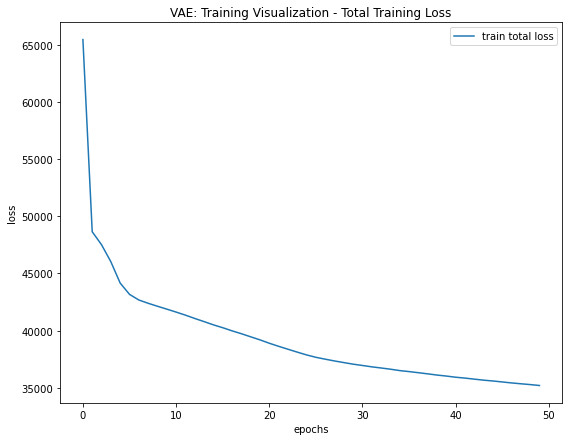

In [56]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

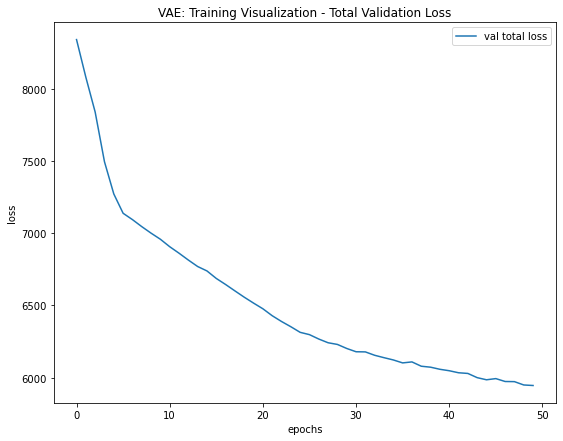

In [57]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_val_loss'] for e in training_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

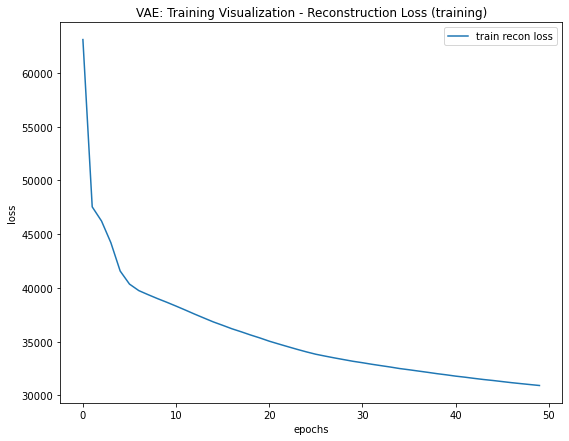

In [58]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

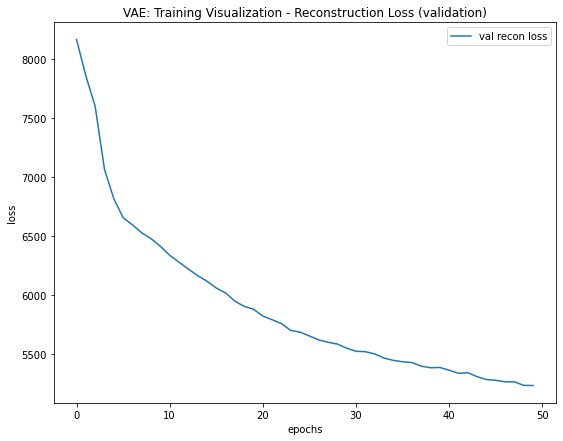

In [59]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_val_loss'] for e in training_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

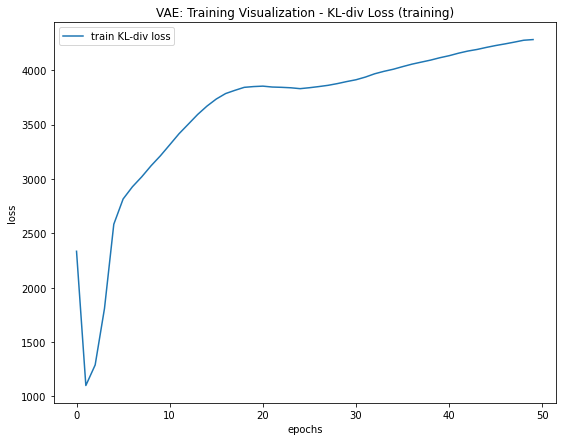

In [60]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

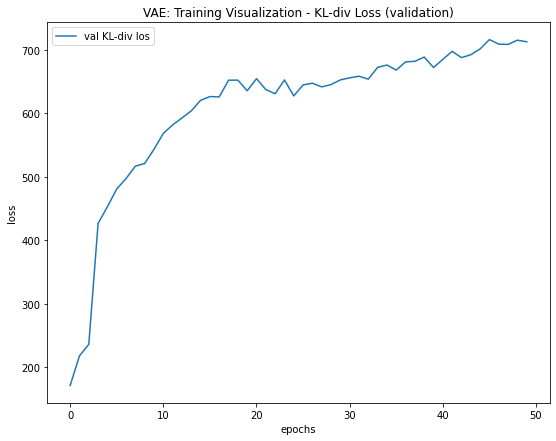

In [61]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['val_kl_loss'] for e in training_metrics.keys()], label = 'val KL-div los')
plt.legend(loc = 'best')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [68]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:, :])

In [69]:
# Sanity check-
X_train[:, :].shape, X_train_reconstruced.shape

((60000, 784), TensorShape([60000, 784]))

In [70]:
# Reshape for visualization-
X_train_reconstruced = tf.reshape(
    tensor = X_train_reconstruced,
    shape = ((X_train_reconstruced.shape[0], 28, 28)),
    name = None
    )

In [71]:
# Sanity check-
X_train_reconstruced.numpy().shape

(60000, 28, 28)

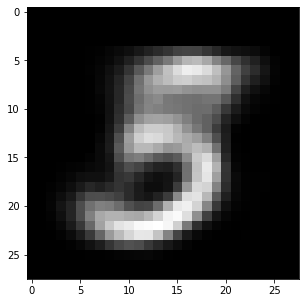

In [66]:
# Visualize a single digit-
plt.figure(figsize = (6, 5))
plt.imshow(X_train_reconstruced[0], cmap = plt.get_cmap('gray'))
plt.show()

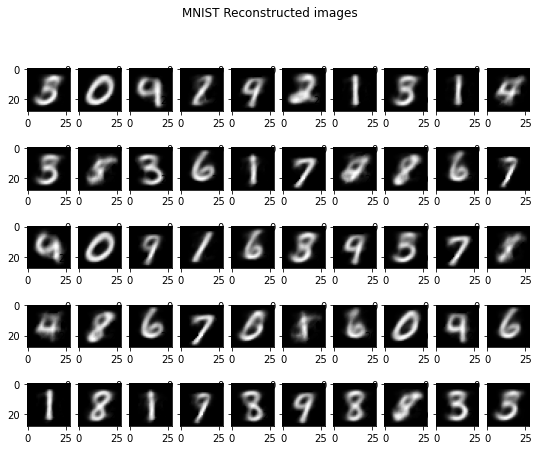

In [72]:
# Visualize some of the reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(X_train_reconstruced[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [73]:
mu.shape, log_var.shape

(TensorShape([60000, 3]), TensorShape([60000, 3]))

In [74]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = 0.0246 & std dev = 0.8243


In [75]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -3.018380 & std dev = 2.2199


### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

In [ ]:
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train
    )
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train
    )
fig.show()

In [79]:
# Delete variables to free GPU space-
del X_train_reconstruced, mu, log_var

### Visualize _latent space_ of train & test datasets

In [80]:
X_train_encoded = model.encoder(X_train)
X_test_encoded = model.encoder(X_test)

In [81]:
X_train.shape, X_train_encoded.shape

((60000, 784), TensorShape([60000, 3]))

In [82]:
X_test.shape, X_test_encoded.shape

((10000, 784), TensorShape([10000, 3]))

In [ ]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    color = y_train
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    color = y_test
)
fig.show()

### Get mean and standard deviation for each of the latent variables for encoded data

In [86]:
print("Encoded Training data: Mean & standard-deviation for each latent variable in latent space 'z'\n")
for i in range(3):
    print(f"lv = {i + 1}: mean = {X_train_encoded[:, i].numpy().mean():.4f} &"
          f" std dev = {X_train_encoded[:, i].numpy().std():.4f}")

Encoded Training data: Mean & standard-deviation for each latent variable in latent space 'z'

lv = 1: mean = 2.9625 & std dev = 0.9063
lv = 2: mean = 3.3614 & std dev = 1.1289
lv = 3: mean = 3.5749 & std dev = 0.9113


In [87]:
print("Encoded Testing data: Mean & standard-deviation for each latent variable in latent space 'z'\n")
for i in range(3):
    print(f"lv = {i + 1}: mean = {X_test_encoded[:, i].numpy().mean():.4f} &"
          f" std dev = {X_test_encoded[:, i].numpy().std():.4f}")

Encoded Testing data: Mean & standard-deviation for each latent variable in latent space 'z'

lv = 1: mean = 2.9593 & std dev = 0.8959
lv = 2: mean = 3.3637 & std dev = 1.1323
lv = 3: mean = 3.5783 & std dev = 0.8940


### Visualize _latent space_ distributions for all latent variables

In [88]:
# Compute number of bins using rule of thumnb-
num_bins = int(np.ceil(np.sqrt(len(X_train_encoded[:, 0]))))
print(f"number of bins - rule of thumb = {num_bins}")

number of bins - rule of thumb = 245


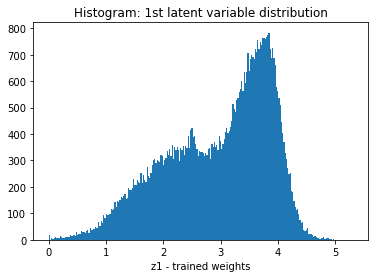

In [89]:
n, b, _ = plt.hist(X_train_encoded[:, 0].numpy(), bins = num_bins)
plt.title("Histogram: 1st latent variable distribution")
plt.xlabel("z1 - trained weights")
plt.show()

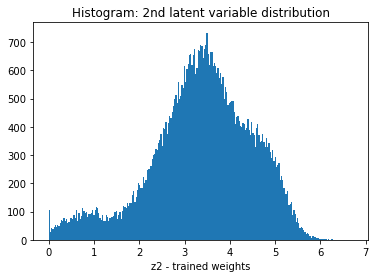

In [90]:
n, b, _ = plt.hist(X_train_encoded[:, 1].numpy(), bins = num_bins)
plt.title("Histogram: 2nd latent variable distribution")
plt.xlabel("z2 - trained weights")
plt.show()

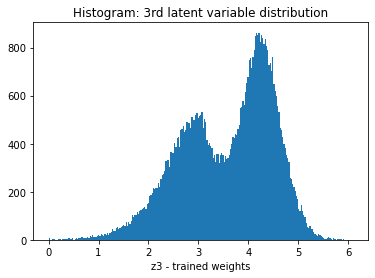

In [91]:
n, b, _ = plt.hist(X_train_encoded[:, 2].numpy(), bins = num_bins)
plt.title("Histogram: 3rd latent variable distribution")
plt.xlabel("z3 - trained weights")
plt.show()

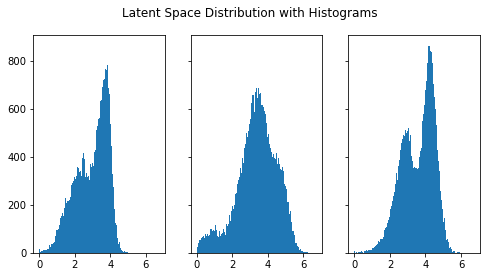

In [93]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 3, 
    sharex = True, sharey = True,
    figsize = (8, 4)
)

i = 0
for col in range(len(axes)):
    # for col in range(len(axes[0])):
    axes[col].hist(X_train_encoded[:, i].numpy(), bins = num_bins)
    i += 1

plt.suptitle("Latent Space Distribution with Histograms")
plt.show()

In [94]:
del X_train_encoded, X_test_encoded